In [1]:
import os
import sys
#sys.path.append(os.path.join(os.getcwd(), '..'))
from ldm.data.deepfashion import DeepFashionSMPL
#from ldm.util import instantiate_from_config
from einops import rearrange
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy

In [2]:
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler


In [3]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

class Parser:
    def __init__(self):
        self.d = dict()

    def add_argument(self, varname, **kwargs):
        field_name = varname.split('--')[-1]
        action = kwargs.get('action', None)
            
        if kwargs.get('default') != None:
            self.d[field_name] = kwargs['default']
            #print(f"{field_name}:{kwargs['default']}")
        elif action:
            self.d[field_name] = False

    def parse_args(self):
        return namedtuple('opt', self.d.keys())(*self.d.values())

In [4]:
    parser = Parser()

    parser.add_argument(
        "--prompt",
        type=str,
        nargs="?",
        default="a painting of a virus monster playing guitar",
        help="the prompt to render"
    )

    parser.add_argument(
        "--outdir",
        type=str,
        nargs="?",
        help="dir to write results to",
        default="outputs/txt2img-samples"
    )

    parser.add_argument(
        "--skip_grid",
        action='store_true',
        help="do not save a grid, only individual samples. Helpful when evaluating lots of samples",
    )

    parser.add_argument(
        "--skip_save",
        action='store_true',
        help="do not save indiviual samples. For speed measurements.",
    )

    parser.add_argument(
        "--ddim_steps",
        type=int,
        default=50,
        help="number of ddim sampling steps",
    )

    parser.add_argument(
        "--plms",
        action='store_true',
        help="use plms sampling",
    )
    parser.add_argument(
        "--fixed_code",
        action='store_true',
        help="if enabled, uses the same starting code across all samples ",
    )

    parser.add_argument(
        "--ddim_eta",
        type=float,
        default=0.0,
        help="ddim eta (eta=0.0 corresponds to deterministic sampling",
    )
    parser.add_argument(
        "--n_iter",
        type=int,
        default=1,
        help="sample this often",
    )

    parser.add_argument(
        "--H",
        type=int,
        default=256,
        help="image height, in pixel space",
    )

    parser.add_argument(
        "--W",
        type=int,
        default=256,
        help="image width, in pixel space",
    )

    parser.add_argument(
        "--C",
        type=int,
        default=4,
        help="latent channels",
    )
    parser.add_argument(
        "--f",
        type=int,
        default=8,
        help="downsampling factor, most often 8 or 16",
    )

    parser.add_argument(
        "--n_samples",
        type=int,
        default=8,
        help="how many samples to produce for each given prompt. A.k.a batch size",
    )

    parser.add_argument(
        "--n_rows",
        type=int,
        default=0,
        help="rows in the grid (default: n_samples)",
    )

    parser.add_argument(
        "--scale",
        type=float,
        default=5.0,
        help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
    )

    parser.add_argument(
        "--dyn",
        type=float,
        help="dynamic thresholding from Imagen, in latent space (TODO: try in pixel space with intermediate decode)",
    )
    parser.add_argument(
        "--from-file",
        type=str,
        help="if specified, load prompts from this file",
    )
    parser.add_argument(
        "--config",
        type=str,
        default="logs/f8-kl-clip-encoder-256x256-run1/configs/2022-06-01T22-11-40-project.yaml",
        help="path to config which constructs model",
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        default="logs/f8-kl-clip-encoder-256x256-run1/checkpoints/last.ckpt",
        help="path to checkpoint of model",
    )
    parser.add_argument(
        "--seed",
        type=int,
        default=42,
        help="the seed (for reproducible sampling)",
    )
    parser.add_argument(
        "--precision",
        type=str,
        help="evaluate at this precision",
        choices=["full", "autocast"],
        default="autocast"
    )


In [5]:
parser.d['config'] = 'configs/deepfashion/deepfashion_inshop_smpl.yaml'
parser.d['ckpt'] = 'logs/2022-10-31T18-30-10_deepfashion_inshop_smpl/checkpoints/epoch=000034.ckpt'
#parser.d['ckpt'] = 'logs/2022-10-31T18-30-10_deepfashion_inshop_smpl/checkpoints/last.ckpt'

opt = parser.parse_args()
config = OmegaConf.load(opt.config)

'''
params = {
    'pickle_file': 'data/deepfashion/deepfashion_1.pickle',
    'folder': '/home/soon/datasets/deepfashion/img_256',
    'smpl_folder': '/home/soon/datasets/smpl/deepfashion/img_256',
    'is_train': False}

ds = DeepFashionSMPL(**params)
'''


"\nparams = {\n    'pickle_file': 'data/deepfashion/deepfashion_1.pickle',\n    'folder': '/home/soon/datasets/deepfashion/img_256',\n    'smpl_folder': '/home/soon/datasets/smpl/deepfashion/img_256',\n    'is_train': False}\n\nds = DeepFashionSMPL(**params)\n"

In [6]:
model = load_model_from_config(config, f"{opt.ckpt}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()

Loading model from logs/2022-10-31T18-30-10_deepfashion_inshop_smpl/checkpoints/epoch=000034.ckpt
Global Step: 50435
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 425.29 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/soon/github/stable-diffusion-finetune/models/first_stage_models/kl-f8/model.ckpt


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.self_attn.out_proj.weight', 'vision_model.encoder.layers.23.mlp.fc2.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'text_projection.weight', 'vision_model.encoder.layers.5.mlp.fc1.weight', 'vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.19.layer_norm1.weight', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.16.layer_norm2.weight', 'vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.15.mlp.fc2.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.layer_norm1.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.3.self_at

LatentDiffusion(
  (model): DiffusionWrapper(
    (diffusion_model): UNetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=224, out_features=896, bias=True)
        (1): SiLU()
        (2): Linear(in_features=896, out_features=896, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 224, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=896, out_features=224, bias=True)
            )
            (out_layers): Sequential(
              (0): Gro

In [9]:
def generate(batch, fixes={}):
    local_batch = deepcopy(batch)
    for key, value in fixes.items():
        repeat_n = len(local_batch[key])
        x = local_batch[key]
        if type(x) == list:
            if type(value) == str:
                local_batch[key] = [value] * repeat_n
            elif type(x[value]) == int:
                local_batch[key] = [x[value]] * repeat_n
            else:
                raise ValueError
        else:
            dim_n = len(x.shape)-1
            local_batch[key] = x[value].repeat(repeat_n, *[1]*dim_n)

    #def run(batch):
    with torch.no_grad():
        images = model.log_images(local_batch, inpaint=False, plot_denoise_rows=False, plot_progressive_rows=False)
    clamp = True
    k = 'samples'

    if isinstance(images[k], torch.Tensor):
        images[k] = images[k].detach().cpu()
        if clamp:
            images[k] = torch.clamp(images[k], -1., 1.)
        images[k] = rearrange(images[k].detach().cpu().numpy(),'b c h w -> b h w c' ) *0.5 + 0.5
        
    
    concat_images = np.concatenate((images['samples'], local_batch['smpl_image'].numpy()*0.5+0.5), axis=2)
    return concat_images


In [7]:
batch_size = 8
config['data']['params']['batch_size'] = batch_size

data = instantiate_from_config(config['data'])
data.prepare_data()
data.setup()

dl = iter(data.train_dataloader())

In [14]:
batch = next(dl)
#batch['txt'] = ['the lady is wearing a navy-magenta dresses'] * batch_size


In [33]:
#fixes = {'smpl':4, 'smpl_image':4}
fixes = {'txt': 'the woman is wearing red multi-color jacket'}
concat_images = generate(batch, fixes)

Plotting: Switched to EMA weights
Data shape for DDIM sampling is (8, 4, 32, 32), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.01it/s]


Plotting: Restored training weights


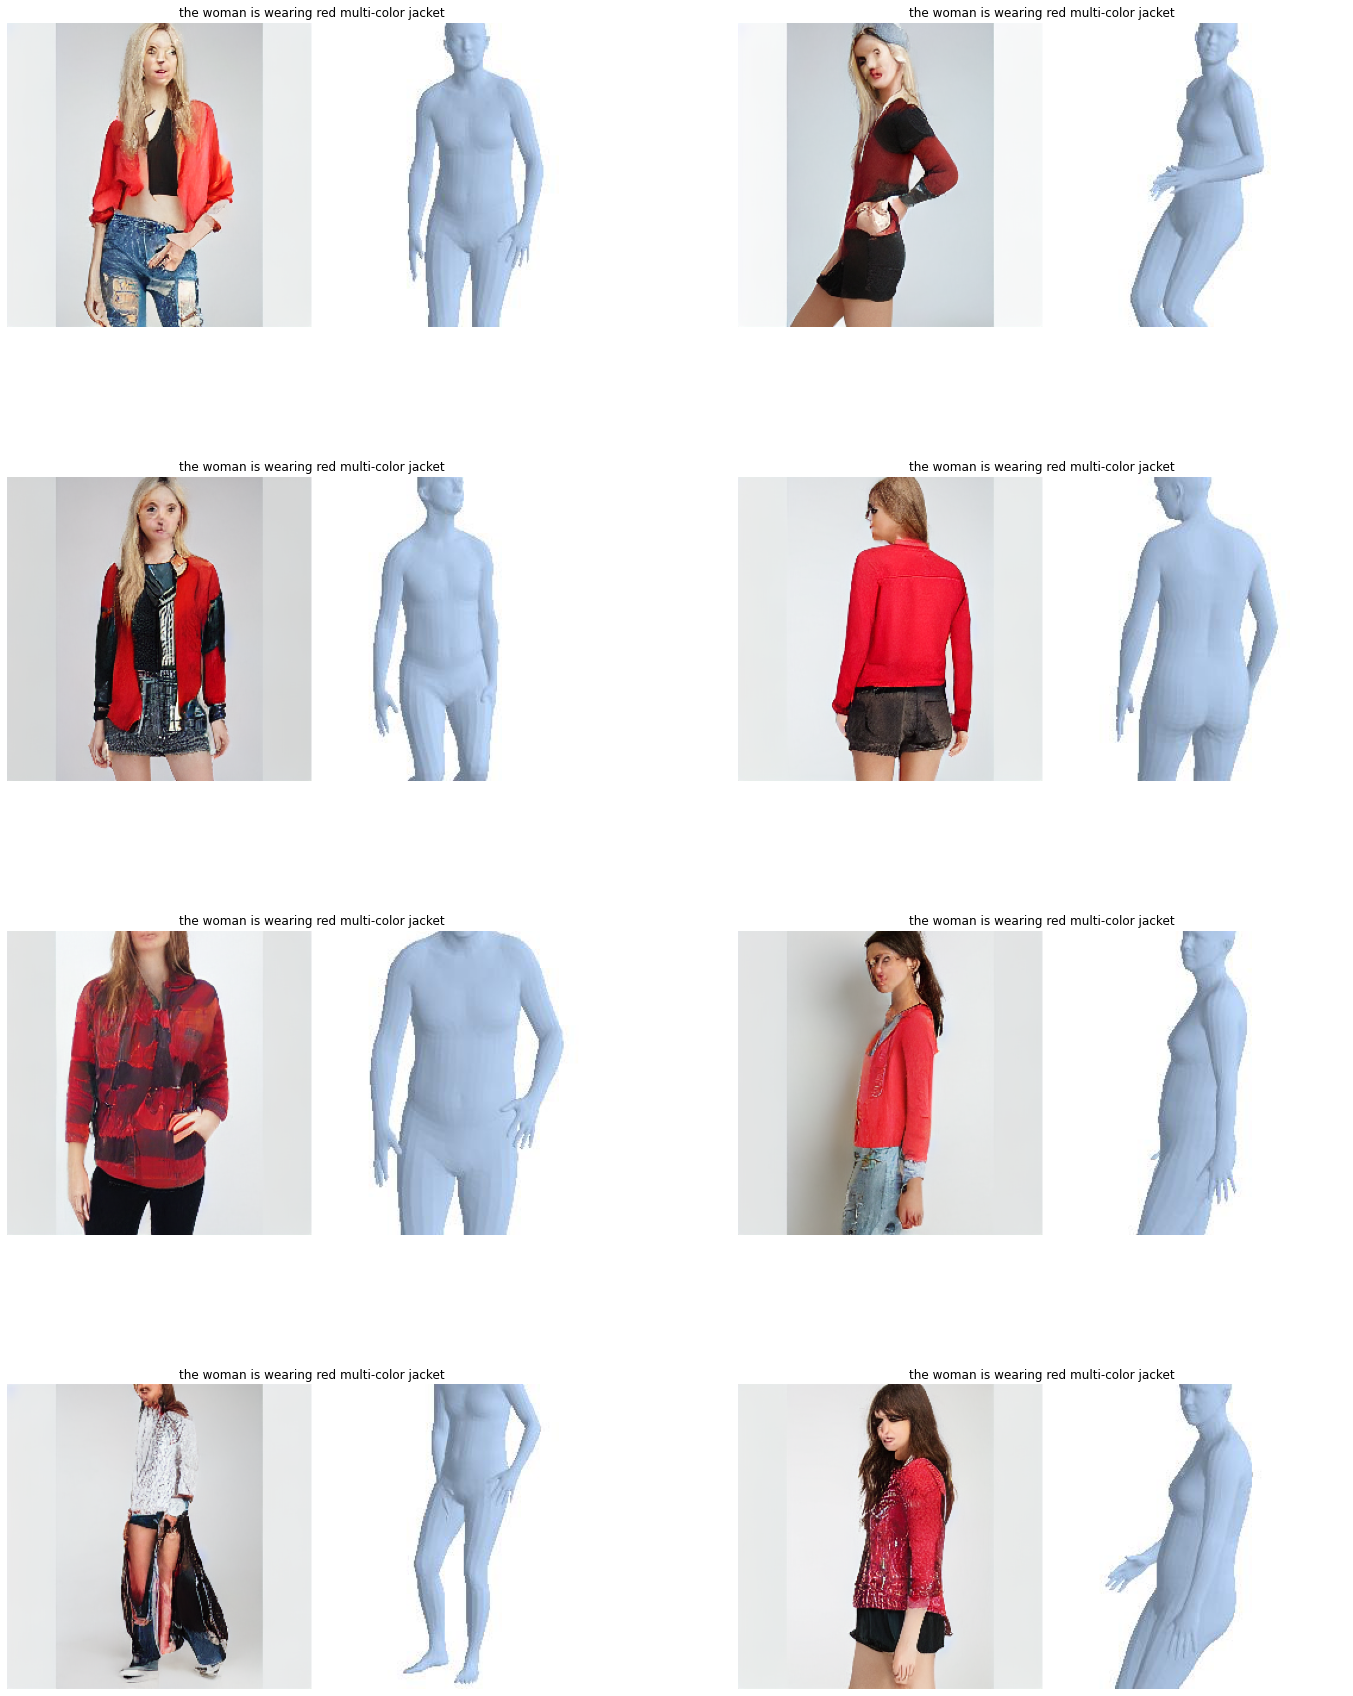

In [34]:
cols = 2
rows = len(concat_images) // cols

f, axarr = plt.subplots(rows, cols)
f.set_figheight(rows*8)
f.set_figwidth(cols*12)

index = 0
for i in range(rows):
    for j in range(cols):
        if rows == 1:
            ax = axarr[j]
        else:
            ax = axarr[i, j]
        
        #axarr[i, j].imshow(Image.open(pose_paths[index]))
        ax.imshow(concat_images[index])
        ax.axis('off')
        title = fixes.get('txt', batch['txt'][index])
        ax.set_title(title)
        index += 1
